This module contains the implementation of the PPO algorithm.
Ci basiamo sullo pseudocodice presente sul sito di OpenAI per la realizzazione del ppo.
https://spinningup.openai.com/en/latest/algorithms/ppo.html#id7
Utilizzando un Actor-Critic Method.
Ciò suddivide l'implementazione in 8 passi principali:
1. Inizializzazione dell'ambiente con policy parameters theta_0, e l'inizial value function parameters w_0.
2. Ciclare per k iterazioni
3. Raccogliere un set di traiettorie D_k = {τ_i} con una policy pi_k = pi(theta_k)
4. Calcolare i reward-to-go R_t
5. Calcolare gli advantage estimates A_t basandoci sulla value function V_{w_k}
6. Aggiornare la policy massimizzando la PPO-Clip objective (Gradient ascent con adam) . Non scriverò la formula che è complessa
7. Aggiornare la value function minimizzando la MSE tra V_{w_k} e R_t (Gradient descent con adam)
8. Fine ciclo.

Implementiamo tutti i passi nella funzione learn.

In [33]:
import warnings
warnings.filterwarnings('ignore') #ignora warnings
#Check if colab is used:
from rete import ReteNeurale
import tensorflow as tf
import tensorflow_probability as tfp
import gym
import numpy as np
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import glfw
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
  print("Not running on CoLab")
  #print list of GPUs
  #tf. config. list_physical_devices('GPU')
  print("Devices: ", tf.config.list_physical_devices())
  print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if IN_COLAB:
  !pip install procgen
  !pip install tensorflow_probability
  !pip install numpy


Not running on CoLab
Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [34]:
#Tutta questa parte è relativa alla visualizzazione del gioco tramite salvataggio degli stati di un episode in una specifica cartella.
#Tutto questo viene fatto perchè non si riesce a visualizzare procgen in live per problemi con glfw e openGL su Ubuntu.
from moviepy import ImageSequenceClip
from IPython.display import Video
import os
from pyvirtualdisplay.smartdisplay import SmartDisplay
display = SmartDisplay(visible=0, size=(1920,1080),fbdir='/tmp')
display.start()
glfw.init()
available_fbconfigs = glfw.get_video_modes(glfw.get_primary_monitor())
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'




In [ ]:
class PPO:
    def __init__(self,env,gameName,totalSteps=2000000):
        self.env=env
        self.gameName=gameName
        self.nAzioni=env.action_space.n
        self.nStati=env.observation_space.shape
        self.listaAzioni=[i for i in range(self.nAzioni)]
        #self.nTimestampsPerBatch=8192
        self.nTimestampsPerBatch=4096
        self.updates_per_iteration=5
        self.stepsPerEpisode=1024
        self.nTotalTimestamps=totalSteps
        self.episodesPerBatch=10
        self.nEpoche=300
        self.gamma=0.99
        self.epsilon=0.2
        self.learningRate=1e-4
        self.policyNN=ReteNeurale(self.nStati,self.nAzioni,True) #Actor
        self.policy_optimizer=keras.optimizers.Adam(learning_rate=self.learningRate, clipnorm=1.0)
        self.policyNN.compile(optimizer=self.policy_optimizer)

        #self.valueNN=ReteNeurale(self.nStati,1) #Critic
        #self.value_optimizer=keras.optimizers.Adam(learning_rate=self.learningRate,clipnorm=1.0)
        #self.valueNN.compile(optimizer=self.value_optimizer)

        self.entropyCoefficient=0.01 #Per invogliare l'esplorazione un po di più.
        self.lambdaGAE=0.95
        self.updateLearningRateEveryTimesteps=100000 #Aggiorna il learning rate ogni x steps dove x è il valore della variabile
        self.csvPath="./rewards/"+self.gameName+"_rewards.csv"
        self.offsetCsv=0 #Usato per capire da quale riga iniziare a scrivere i rewards. Per non sovrascrivere i vecchi rewards.
        self.batchSize=128
        #Creo il file csv per salvare i rewards
        if not os.path.isfile(self.csvPath):
            data = {"Epoch": [], "Average reward": [], "Min reward": [], "Max reward": []}
            df=pd.DataFrame(data,columns=["Epoch","Average reward","Min reward","Max reward"])
            df.to_csv(self.csvPath,index=False,header=True)
        else:
            df=pd.read_csv(self.csvPath)
            self.offsetCsv=len(df.index)
        

    def learn(self):
        #passo 2 ciclare per k iterazioni.
        stepsTot=0
        iterazioniTot=0
        while stepsTot<self.nTotalTimestamps:
            print("Step totali eseguiti: {}".format(stepsTot)," Step totali rimasti:",self.nTotalTimestamps-stepsTot)
            self.updateLearningRate(stepsTot) 
            states, actions, rewards_to_go, log_probs, dones,len_ep =self.collect_trajectories()
            stepsTot+=np.sum(len_ep)
            iterazioniTot+=1
            num_samples=np.sum(len_ep)
            print("NUM SAMPLES:",num_samples)

            samplesInPiu=num_samples%self.batchSize
            batch_size=self.batchSize+samplesInPiu

            i=0
            while i <num_samples:
                batch_states=states[i:i+batch_size]
                batch_actions=actions[i:i+batch_size]
                batch_rewards_to_go=rewards_to_go[i:i+batch_size]
                batch_log_probs=log_probs[i:i+batch_size]
                batch_dones=dones[i:i+batch_size]

                v,_,_=self.evaluate(batch_states,batch_actions)
                #advantage=self.calcAdvantages(batch_rewards_to_go,V)
                advantage, targets =self.calcGaeAndTargets(batch_rewards_to_go, v, batch_dones)
                with tf.GradientTape() as tape:
                    #v,latest_log_probs,_=self.evaluate(batch_states,batch_actions)                    
                    v,latest_log_probs,logits=self.evaluate(batch_states,batch_actions)

                    #Aggiungo entropia alla loss per incentivare l'esplorazione
                    entropy=self.getEntropyLoss(logits)
                    #entropy = -tf.reduce_mean(probs * tf.math.log(probs + 1e-10))

                    policy_loss = self.getPolicyLoss(batch_log_probs,latest_log_probs,advantage) + entropy*self.entropyCoefficient
                    #MSE valueLoss
                    value_loss = tf.reduce_mean(tf.square(targets - v)) * 0.5
                    
                    total_loss=policy_loss+ value_loss*0.5
                gradientsPolicy = tape.gradient(total_loss, self.policyNN.trainable_variables)
                #gradientsValue = tape.gradient(value_loss, self.valueNN.trainable_variables)
                #self.value_optimizer.apply_gradients(zip(gradientsValue, self.valueNN.trainable_variables))
                grads, grad_norm = tf.clip_by_global_norm(gradientsPolicy, 0.5)               # clip gradients for slight updates

                self.policy_optimizer.apply_gradients(zip(grads, self.policyNN.trainable_variables))

                i+=batch_size
                batch_size=self.batchSize
                print("EPOCA:",iterazioniTot," POLICY LOSS:",policy_loss.numpy()," VALUE LOSS:",value_loss.numpy()," ENTROPY:",entropy.numpy())
            self.evaluate_policy(epoch=iterazioniTot)
            if iterazioniTot%10==0:
                self.saveModel("./weights/ppo_"+self.gameName+".weights.h5")
                


    def getEntropyLoss(self, logits=None):
        """
            Entropy term for more randomness which means more exploration \n
            Based on OpenAI Baselines implementation
        """
        a0 = logits - tf.reduce_max(logits, axis= -1, keepdims=True)
        exp_a0 = tf.exp(a0)
        z0 = tf.reduce_sum(exp_a0, axis= -1, keepdims=True)
        p0 = exp_a0 / z0
        entropy = tf.reduce_sum(p0 * (tf.math.log(z0) - a0), axis= -1)
        return -tf.reduce_mean(entropy)
    
    def evaluate_policy(self, episodes=10,epoch=0):
        total_rewards = []
        for i in range(episodes):
            frames=[]

            state = self.env.reset()
            done = False
            cumulative_reward = 0
            while not done:
                state_tensor=tf.convert_to_tensor(np.expand_dims(state, axis=0) ,dtype=tf.float32)# Diventa (1, 64, 64, 3)
                probs,_= self.policyNN(state_tensor)
                action = np.argmax(probs.numpy())
                next_state, reward, done, _ =self.env.step(action)
                if not np.array_equal(next_state,state):
                    print("taken action: ",action, "with prob: ",tf.squeeze(probs).numpy()[action])

                state=next_state
                frames.append(state)
                cumulative_reward += reward
            total_rewards.append(cumulative_reward)
            self.saveClip(frames,i)
            
            print("Episode reward:", cumulative_reward)
        print(f"Average Reward: {np.mean(total_rewards):.2f}")
        self.saveReward(np.mean(total_rewards),np.min(total_rewards),np.max(total_rewards),epoch,"./rewards/"+self.gameName+"_rewards.csv")

    def collect_trajectories(self):
        #Passo 3 --> Raccogliere un set di traiettorie D_k = {τ_i} con una policy pi_k = pi(theta_k)
        #Dobbiamo raccogliere un set di traiettorie e per fare ciò dobbiamo raccogliere: stati, azioni, rewards, rewards to go, log_prob delle azioni.
        batch={
            'states':[],
            'actions':[],
            'rewards':[],
            'rewards_to_go':[],
            'log_probs':[],
            'done':[],
            'lengths':[]
        }

        t = 0 # Keeps track of how many timesteps we've run so far this batch
        nEpisodes=0
        while t < self.nTimestampsPerBatch:
            rewardPerEpisode=[]
            stato = self.env.reset()
            done = False
            frames=[]
            for i in range(self.stepsPerEpisode):
                t+=1
                batch['states'].append(stato)
                azione,log_prob=self.getAction(stato)
                batch['actions'].append(azione)
                batch['log_probs'].append(log_prob)
                stato, reward, done ,_= self.env.step(azione)  #al posto di _ ci sarebbe info ma non ci serve
                rewardPerEpisode.append(reward)
                frames.append(stato)
                batch['done'].append(done)
                if done :
                    break #Ha raggiunto il termine dell'episodio.
            batch['rewards'].append(rewardPerEpisode)
            batch['lengths'].append(i+1)
            nEpisodes+=1
            #self.saveClip(frames,nEpisodes)
            frames=[]
        #Calcoliamo i rewards to go --> PASSO 4
        batch['rewards_to_go']=self.calcRTG(batch['rewards'])
        batch_statiTensor=tf.convert_to_tensor(batch['states'],dtype=tf.uint8)
        batch_azioniTensor=tf.convert_to_tensor(batch['actions'],dtype=tf.int32)
        batch_rewards_to_goTensor=tf.convert_to_tensor(batch['rewards_to_go'],dtype=tf.float32)
        batch_log_probsTensor=tf.convert_to_tensor(batch['log_probs'],dtype=tf.float32)
        batch_len=tf.convert_to_tensor(batch['lengths'],dtype=tf.int32)


        return batch_statiTensor, batch_azioniTensor,batch_rewards_to_goTensor,batch_log_probsTensor, batch['done'],batch_len

    def getAction(self,stato):
        stato=tf.convert_to_tensor(np.expand_dims(stato, axis=0) ,dtype=tf.float32)# Diventa (1, 64, 64, 3)
        logits,_=self.policyNN(stato)
        #Somma probabilità
        #dist=tfp.distributions.Categorical(probs=tf.squeeze(azione_pred).numpy())
        #azionePresa=dist.sample()
        #log_prob=dist.log_prob(azionePresa)
        action=tf.squeeze(tf.random.categorical(logits, 1), axis=-1)
        #dist=tfp.distributions.Categorical(probs=mean)
        log_prob=self.logp(logits,action)
        
        return np.squeeze(action),np.squeeze(log_prob)

    def calcRTG(self,rewards):
        #Prendo la formula per calcolare i rewards to go e richiede i cumulative rewards e un fattore di sconto.
        rtg=[]
        for episode_reward in reversed(rewards):
            cumulative_reward=0
            totalRewardPerEpisode=0
            for single_reward in reversed(episode_reward):
                cumulative_reward=single_reward+cumulative_reward*self.gamma
                totalRewardPerEpisode+=single_reward
                rtg.append(cumulative_reward)
            print("Total reward per episode RTG:",totalRewardPerEpisode)
        return tf.convert_to_tensor(rtg,dtype=tf.float32)

   
    def calcGaeAndTargets(self,rewards,values,dones):
        advantages = []
        targets = []
        advantage = 0
        try:
            tf.debugging.check_numerics(rewards, "Ricompense non valide")
            tf.debugging.check_numerics(values, "Valori non validi")
            
        except:
            print("Errore: ",rewards , values, dones)
        for t in reversed(range(len(rewards))):

            #Se una delle variabili è solo un valore, allora non posso fare slicing e devo fare un controllo.
            if t+1<len(rewards):
                delta=rewards[t]+ (1-dones[t])*self.gamma*values[t+1]-values[t]
            else:
                delta=rewards[t]-values[t]
            advantage=delta+self.gamma*self.lambdaGAE*(1-dones[t])*advantage
            advantage= (advantage - np.mean(advantage)) / (np.std(advantage) + 1e-10)

            advantages.append(advantage)
            targets.append(advantage + values[t])
        return tf.convert_to_tensor(advantages, dtype=tf.float32), tf.convert_to_tensor(targets, dtype=tf.float32)


    def getPolicyLoss(self,log_probs_old, log_probs_new, advantages):
        
        advantages_t = tf.stop_gradient(advantages)
        policy_ratio_t = tf.exp(log_probs_new-log_probs_old)
        print("Policy ratio: ",policy_ratio_t)
        loss= policy_ratio_t * advantages_t
        clipped_policy_ratio=tf.clip_by_value(policy_ratio_t, clip_value_min=1.0-self.epsilon, clip_value_max=1.0+self.epsilon)
        loss_clipped = clipped_policy_ratio * advantages_t
        clip_loss=tf.minimum(loss,loss_clipped)
        return -tf.reduce_mean(clip_loss)

    def evaluate(self, batch_states,batch_actions, training=True):
        batch_states=tf.cast(batch_states, tf.float32)
        logits,v=self.policyNN(batch_states,training=training)
        #v=self.valueNN(batch_states,training=training)
        #mean = tf.clip_by_value(mean, 1e-10, 1.0)  # Evita valori molto bassi
        #mean /= tf.reduce_sum(mean, axis=-1, keepdims=True)  # Normalizza
        v= tf.squeeze(v)
        action=tf.squeeze(tf.random.categorical(logits, 1), axis=-1)
        #dist=tfp.distributions.Categorical(probs=mean)
        log_probs=self.logp(logits,action)
        #log_probs=dist.log_prob(batch_actions)
        return v, np.squeeze(log_probs), np.squeeze(logits)


    def logp(self, logits,action):
        logp_all = tf.nn.log_softmax(logits)
        one_hot = tf.one_hot(action, depth= self.nAzioni)
        return tf.reduce_sum( one_hot * logp_all, axis= -1)

    def loadModel(self, path):
        if path is "":
            return
        self.policyNN.build(self.nStati)
        try:
            #Check if weights contains Nan or Inf
            self.policyNN.load_weights(path)
            for var in self.policyNN.trainable_variables:
                tf.debugging.check_numerics(var, "LOAD Contiene NAN o INF")
        except:
            print("Errore nel caricamento del modello")


    def saveModel(self, path):
        #Controllo che la cartella esista e che non ci siano NaN nei pesi
        if not os.path.exists("weights"):
            os.makedirs("weights")
        try:
            for var in self.policyNN.trainable_variables:
                tf.debugging.check_numerics(var, "SAVE Contiene NAN o INF")
        except: 
            print("Errore: i pesi contengono NaN o Inf. Non verrà salvato")
            return
        
        self.policyNN.save_weights(path)
    
    def updateLearningRate(self, epoch):
      if epoch % self.updateLearningRateEveryTimesteps == 0 and epoch > 0:
        self.learningRate *= 0.9  # Riduci il learning rate del 10%
        self.policy_optimizer.learning_rate = self.learningRate #Aggiorno solo dentro l'if che tanto è uguale per tutte le altre volte.   

    def saveReward(self,reward,minReward,maxReward,epoch,path):
        #Devo controllare se c'è davvero il file o meno. In caso affermativo conto quante righe ci sono.Da li ci sarà un offset così da incrementare correttamente
        epoch+=self.offsetCsv        
        data = {"Epoch": [epoch], "Average reward": [reward], "Min reward": [minReward], "Max reward": [maxReward]}
        df=pd.DataFrame(data,columns=["Epoch","Average reward","Min reward","Max reward"])
        df.to_csv(path,mode='a',index=False,header=False)

    def showGraph(self):
        rewards=pd.read_csv("./rewards/"+self.gameName+"_rewards.csv")
        #Plotto i rewards mostrando anche il minimo e il massimo valore.
        rewards.plot(x='Epoch',y='Average reward',kind='line',title="Average reward per epoch")        
        plt.show()
    
    def saveClip(self,frames,i):
        clip = ImageSequenceClip(list(frames), fps=15)
        nameVideo="./clip/"+self.gameName+"/"+  self.gameName+"_video"+str(i)+".mp4"
        clip.write_videofile(nameVideo, fps=15,logger=None)
        Video(nameVideo)


In [ ]:
# Configurazione ed esecuzione
#Lista di giochi a disposizione di Procgen:
""" 
    bigfish, bossfight, caveflyer, chaser, climber
    coinrun, dodgeball, fruitbot, heist, jumper
    leaper, maze, miner, ninja, plumber, starpilot
"""
seed=42
gameName="coinrun" #Scelto starpilot perchè è un gioco che ha episode corti, quindi allenamenti più rapidi.
env = gym.make('procgen:procgen-'+gameName+'-v0',distribution_mode='easy',start_level=seed,rand_seed=seed, num_levels=1, use_backgrounds=False)

#Creo l'oggetto PPO
ppo_model=PPO(env,gameName)

#load model weights if available 
ppo_model.loadModel("./weights/ppo_"+gameName+".weights.h5")
ppo_model.learn()

#save model weights
ppo_model.saveModel("./weights/ppo_"+gameName+".weights.h5")



Errore nel caricamento del modello
Step totali eseguiti: 0  Step totali rimasti: 2000000
Total reward per episode RTG: 10.0
Total reward per episode RTG: 10.0
Total reward per episode RTG: 10.0
Total reward per episode RTG: 10.0
Total reward per episode RTG: 10.0
Total reward per episode RTG: 10.0
Total reward per episode RTG: 10.0
Total reward per episode RTG: 10.0


2024-12-29 17:14:35.898457: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 477757440 exceeds 10% of free system memory.


NUM SAMPLES: 4860
EPOCA: 1  POLICY LOSS: -0.026988897  VALUE LOSS: 0.0069983457  ENTROPY: -2.6988897
EPOCA: 1  POLICY LOSS: -0.026988873  VALUE LOSS: 0.0045249276  ENTROPY: -2.6988873
EPOCA: 1  POLICY LOSS: -0.02699397  VALUE LOSS: 0.0008194441  ENTROPY: -2.699397
EPOCA: 1  POLICY LOSS: -0.026995433  VALUE LOSS: 0.001855646  ENTROPY: -2.6995435
EPOCA: 1  POLICY LOSS: -0.026997408  VALUE LOSS: 0.0014489068  ENTROPY: -2.699741
EPOCA: 1  POLICY LOSS: -0.026997313  VALUE LOSS: 0.0010189177  ENTROPY: -2.6997313
EPOCA: 1  POLICY LOSS: -0.026997318  VALUE LOSS: 0.0022035148  ENTROPY: -2.6997318
EPOCA: 1  POLICY LOSS: -0.026996626  VALUE LOSS: 0.0015822188  ENTROPY: -2.6996627
EPOCA: 1  POLICY LOSS: -0.02699086  VALUE LOSS: 0.0018172478  ENTROPY: -2.6990862
EPOCA: 1  POLICY LOSS: -0.02699675  VALUE LOSS: 0.0037012028  ENTROPY: -2.699675
EPOCA: 1  POLICY LOSS: -0.027000915  VALUE LOSS: 0.0012873795  ENTROPY: -2.7000916
EPOCA: 1  POLICY LOSS: -0.027003357  VALUE LOSS: 0.0011438923  ENTROPY: -2.7

I0000 00:00:1735379183.514953    4032 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2784 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


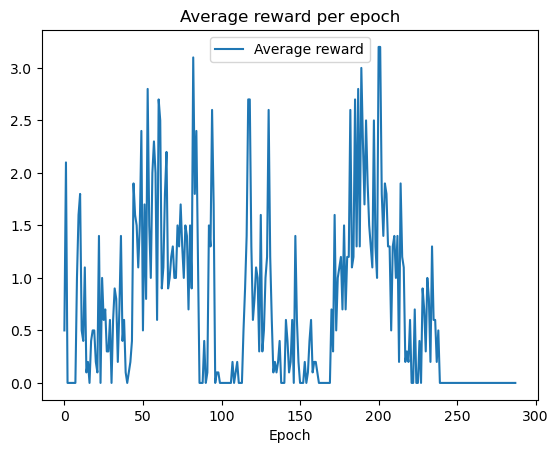

In [ ]:
ppo_model.showGraph()